In [1]:
import qadence as qd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator
from qiskit_aer import AerSimulator

INFO  2025-01-05 23:56:58 - pyqtorch: PyQTorch logger successfully setup with log level 20
2025-01-05 23:57:00.682180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-05 23:57:00.697465: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-05 23:57:00.697495: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 23:57:00.708216: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlo

In [2]:
lambda_ = 8
kappa = 0.1
u0 = 1

In [3]:
def chebyshev_tower_feature_map(qc, x, num_qubits):
    for i in range(num_qubits):
        angle = 2 * (i + 1) * np.arccos(x)
        qc.ry(angle, i)

In [4]:
def variational_ansatz(qc, params, num_qubits):
    for layer in params:
        for i in range(num_qubits):
            qc.ry(layer[i], i)
        for i in range(num_qubits - 1):
            qc.cx(i, i + 1)

In [5]:
def build_circuit(x, params, num_qubits):
    qc = QuantumCircuit(num_qubits)
    chebyshev_tower_feature_map(qc, x, num_qubits)
    variational_ansatz(qc, params, num_qubits)
    return qc

In [6]:
def quantum_model(x, params, num_qubits):
    qc = build_circuit(x, params, num_qubits)
    observable = SparsePauliOp.from_list([("Z" + "I" * (num_qubits - 1), 1.0)])
    estimator = Estimator()
    result = estimator.run([qc], [observable]).result()
    return float(result.values[0])

In [7]:
def loss_function(params, x_values, num_qubits):
    print("Evaluating loss")
    diff_loss = 0
    delta = 1e-4
    for x in x_values:
        u_x = quantum_model(x, params, num_qubits)
        du_dx = (quantum_model(x + delta, params, num_qubits) - u_x) / delta
        residual = du_dx + lambda_ * u_x * (kappa + np.tan(lambda_ * x))
        diff_loss += residual**2
    boundary_loss = (quantum_model(0, params, num_qubits) - u0)**2
    total_loss = diff_loss / len(x_values) + boundary_loss
    print(f"Loss computed: {total_loss}")
    return total_loss

In [8]:
num_qubits = 4
num_layers = 3
params = np.random.uniform(0, 2 * np.pi, (num_layers, num_qubits))
x_values = np.linspace(0, 0.9, 20)

In [9]:
def objective(flat_params):
    reshaped_params = flat_params.reshape((num_layers, num_qubits))
    return loss_function(reshaped_params, x_values, num_qubits)

In [10]:
flat_params = params.flatten()
result = minimize(objective, flat_params, method='SLSQP')
optimized_params = result.x.reshape((num_layers, num_qubits))

Evaluating loss
Loss computed: 377.9795611934179
Evaluating loss
Loss computed: 377.9795566731017
Evaluating loss


/tmp/ipykernel_2042858/2079916098.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


Loss computed: 377.9795570069768
Evaluating loss
Loss computed: 377.9795536236743
Evaluating loss
Loss computed: 377.9795624566263
Evaluating loss
Loss computed: 377.9795628153649
Evaluating loss
Loss computed: 377.9795549429287
Evaluating loss
Loss computed: 377.9795599980261
Evaluating loss
Loss computed: 377.97956115704807
Evaluating loss
Loss computed: 377.9795522383746
Evaluating loss
Loss computed: 377.9795600955288
Evaluating loss
Loss computed: 377.97955884704925
Evaluating loss
Loss computed: 377.97955824062507
Evaluating loss
Loss computed: 250.72920870487152
Evaluating loss
Loss computed: 285.4883937365645
Evaluating loss
Loss computed: 50.36304166775231
Evaluating loss
Loss computed: 60.29658088133963
Evaluating loss
Loss computed: 125.1496130961995
Evaluating loss
Loss computed: 10.731027052548885
Evaluating loss
Loss computed: 122.56223167480361
Evaluating loss
Loss computed: 101.00073642464879
Evaluating loss
Loss computed: 67.75259202332099
Evaluating loss
Loss computed

In [11]:
x_test = np.linspace(0, 1, 100)
u_approx = [quantum_model(x, optimized_params, num_qubits) for x in x_test]

u_exact = [np.exp(-kappa * lambda_ * x) * np.cos(lambda_ * x) for x in x_test]

/tmp/ipykernel_2042858/2079916098.py:4: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


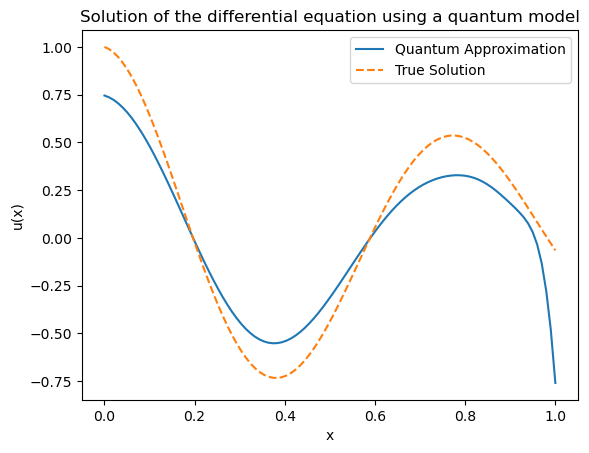

In [12]:
plt.plot(x_test, u_approx, label="Quantum Approximation")
plt.plot(x_test, u_exact, label="True Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("Solution of the differential equation using a quantum model")
plt.show()